In [ ]:
!pip install supervision
!ln -s /home/ubuntu/gdino/GroundingDINO/groundingdino .
!ln -s /home/ubuntu/gdino/GroundingDINO/weights .

In [ ]:
import os

from groundingdino.util.inference import load_model, load_image, predict, annotate
import cv2

model = load_model("groundingdino/config/GroundingDINO_SwinT_OGC.py", "weights/groundingdino_swint_ogc.pth")
GDINO_PATH = "/home/ubuntu/gdino/GroundingDINO"
IMAGE_PATH = f"{GDINO_PATH}/.asset/cat_dog.jpeg"
TEXT_PROMPT = "chair . person . dog ."
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
cv2.imwrite("annotated_image.jpg", annotated_frame)

In [3]:
image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

cv2.imwrite("annotated_image.jpg", annotated_frame)

True

In [ ]:
!pip install opencv-python

### FUNCTIONS

In [3]:
from ast import Tuple
import cv2
from scipy.fftpack import sc_diff
import matplotlib.pyplot as plt
import cv2 as cv
from typing import Any, Generator
import numpy as np
import torch
from PIL import Image

try:
    import groundingdino.datasets.transforms as T
except ImportError:
    print("Could not import groundingdino")

def is_iterable(obj):
    try:
        iter(obj)
        return True
    except TypeError:
        return False
class Stack:
    def __init__(self, max_size):
        self.stack = []
        self.max_size = max_size

    def push(self, item):
        if len(self.stack) == self.max_size:
            self.stack.pop(0)  # Remove the oldest item
        self.stack.append(item)

    def pop(self):
        if len(self.stack) < 1:
            return None
        return self.stack.pop()

    def size(self):
        return len(self.stack)
    def __str__(self):
        return str(self.stack)
    def __iter__(self):
        return iter(self.stack)

def extract_frames(video_path, output_folder, frames_limit=100, skip=0):
    """
        write each frame to a file
    """
    
    os.makedirs(output_folder, exist_ok=True) 

    # Open the video file
    video = cv2.VideoCapture(video_path)



    # Check if video opened successfully
    if not video.isOpened():
        print("Could not open video")
        return

    frame_taken = 0
    iteration = -1
    success = True
    files = []
    while (frames_limit > 0 and frame_taken < frames_limit) or (frames_limit == 0 and success is True):
        iteration += 1

        # Read the next frame from the video. If you read at the end of the video, success will be False
        success, frame = video.read()
        print(f"\r rame_taken {frame_taken} out of {frames_limit}", end=" ")

        # Break the loop if the video is finished
        if not success:
            break
        if skip != 0 and iteration % skip != 0:
            continue

        # Save the frame into the output folder
        cv2.imwrite(f"{output_folder}/frame{frame_taken}_{iteration}.jpg", frame)
        files.append(f"{output_folder}/frame{frame_taken}_{iteration}.jpg")

        frame_taken +=1

    # Release the video file
    video.release()
    return files

def retrieve_frames(video_file: str, frames_limit=10) -> Generator[np.ndarray, None, None]:
    """
        yield each frame as byte array
    """
    video = cv2.VideoCapture(video_file)
    frame_count = 0

    while video.isOpened():
        success, frame = video.read()

        if not ((frames_limit > 0 and frame_count < frames_limit) or (frames_limit == 0 and success is True)):
            break

        yield frame
        frame_count += 1

    video.release()

def plot_image(image: np.ndarray, size: int = 12) -> None:
    %matplotlib inline
    plt.figure(figsize=(size, size))
    plt.imshow(image[...,::-1])
    plt.show()

def zoom_at(img, zoom=1, angle=0, coord=None):

    cy, cx = [ i/2 for i in img.shape[:-1] ] if coord is None else coord[::-1]

    rot_mat = cv2.getRotationMatrix2D((cx,cy), angle, zoom)
    result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    return result

def convert_ndarray(frame: np.ndarray[Any]) ->  torch.Tensor:
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_source = Image.fromarray(frame_rgb)

    # image_source = Image.fromarray(arr).convert("RGB")
    # image_source = Image.open(image_path).convert("RGB")
    # image_source = Image.open(image_path).convert("RGB")
    # image = np.asarray(image_source)
    image_transformed, _ = transform(image_source, None)
    return image_transformed

def add_text_to_frame2(frame, text, position=(50, 50), font_scale=1, font_color=(0, 0, 255), thickness=4):
    """
    Adds text to a single frame.
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    if is_iterable(text):
        for line in text:
            cv2.putText(frame, line, position, font, font_scale, font_color, thickness)
            # position = (position[0], position[1] + 50)
        # text = " ".join(text)
    else:
        cv2.putText(frame, text, position, font, font_scale, font_color, thickness)
    return frame

NameError: name '_C' is not defined

### Extract frames

In [6]:
video_file = "/opt/dlami/nvme/s3sync/GX011620.MP4"

In [ ]:

files = extract_frames(
    video_path=video_file,
    output_folder="output/frames",
    frames_limit=50,
    skip=100
)
files


In [8]:
files

### Using frames

##### Get Video info

In [13]:
import cv2
vid_cap = cv2.VideoCapture(video_file)
fps = vid_cap.get(cv2.CAP_PROP_FPS)
ret, frame = vid_cap.read()
vid_cap.release()
resolution_size = (int(frame.shape[0]), int(frame.shape[1]))
resolution_size, fps


((1520, 2704), 59.94005994005994)

##### Predic and show annotated frames

In [ ]:
# Single image playground

image_name = "frame70_2800"
zoomed_img_path = f"/home/ubuntu/tracker/tracker/output/frames/{image_name}_zoom.jpg"
org_image_path = f"/home/ubuntu/tracker/tracker/output/frames/{image_name}.jpg"
org_img = cv.imread(org_image_path)
# z_img = zoom_at(img, 1.5, coord=(264.5, 275))
cv.imwrite(zoomed_img_path, zoom_at(org_img, 2, coord=(264.5, 800)) )

# Original Image
image_source, image = load_image(org_image_path)
boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption="basketball",
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
plot_image(annotated_frame, 8)

# Zoomed Image
zimage_source, zimage = load_image(zoomed_img_path)
boxes, logits, phrases = predict(
        model=model,
        image=zimage,
        caption="basketball",
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
z_annotated_frame = annotate(image_source=zimage_source, boxes=boxes, logits=logits, phrases=phrases)
print(boxes, logits, phrases)
plot_image(z_annotated_frame, 8)
cv.imwrite(zoomed_img_path, z_annotated_frame )

In [ ]:
import os

import torch
from torchvision.ops import box_convert
from groundingdino.util.inference import load_model, load_image, predict, annotate
# size = (int(img0.shape[1]/2), int(img0.shape[0]/2))
resolution = (int(1024), int(1024))
# Create a new video
h264 = cv.VideoWriter_fourcc('h','2','6','4')
mp4v = cv.VideoWriter_fourcc('m', 'p', '4', 'v')
new_video = cv2.VideoWriter("new_video1.mp4", mp4v, fps, resolution)

for file in files:
    f_name = os.path.basename(file)
    print(file, f_name)
    image_source, image = load_image(file)
    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption="basketball",
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    if boxes.shape[0] == 0:
        continue

    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    print(boxes, logits, phrases)
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    x = xyxy[0][0]
    y = xyxy[0][1]

    # cv2.imwrite(f"output/predict/{f_name}", annotated_frame)
    # cv.imwrite('zoom_frame0.jpg', zoom_at(annotated_frame, 1.5, coord=(264.5, 275)) )

    plot_image(annotated_frame, 8)
    # plot_image(zoom_at(annotated_frame, 2, coord=(x, y)), 1280)
    # new_video.write(annotated_frame)
    # print(boxes, logits, phrases)
    print("--------------")

print("Releasing video")
new_video.release()

In [ ]:
# !conda install -y -c conda-forge ipywidgets # or pip install ipywidgets
# !conda install -n base -c conda-forge jupyterlab_widgets

# !conda install -n base -c conda-forge widgetsnbextension
# !which python
# !pip install ipywidgets widgetsnbextension pandas-profiling



### Using generator

In [ ]:
from typing import Tuple
from tqdm.notebook import tqdm
import groundingdino.datasets.transforms as T
import PIL
import torch
from PIL import Image
from torchvision.ops import box_convert

def load_ndarr_image(numpy_image) -> Tuple[np.array, torch.Tensor]:
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    # image_source = Image.open(image_path).convert("RGB")
    PIL_image = Image.fromarray(np.uint8(numpy_image)).convert('RGB')

    image = np.asarray(PIL_image)
    image_transformed, _ = transform(PIL_image, None)
    return image, image_transformed

frame_iterator = iter(retrieve_frames(video_file="input/basketball.mp4", frames_limit=5))
frames_data = []
for frame in tqdm(frame_iterator, total=5):
    # print(frame)
    print("-------------------")
    image_source, image = load_ndarr_image(frame)
    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption="basketball",
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    frames_data.append((boxes, logits, phrases))

    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

    # cv2.imwrite(f"output/predict/{f_name}", annotated_frame)
    print(boxes, logits, phrases, xyxy)
    plot_image(annotated_frame, 16)


### Zooming

In [34]:
import cv2 as cv

img = cv.imread('output/frames/frame0.jpg')
z_img = zoom_at(img, 1.5, coord=(264.5, 275))
# print(z_img)

# plot_image(annotated_frame, 8)
cv.imwrite('output/test_no_zoom.jpg', img )
cv.imwrite('output/test_zoom.jpg', zoom_at(img, 1, coord=(2264.5, 275)) )

True

### Generate video

In [ ]:
# !sudo apt-get install -y ffmpeg x264 libx264-dev
# !pip install jupyterlab_widgets ipywidgets
!pip install --upgrade ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [21]:


def write_frame(vid_writer, source_frame, history: Stack,  boxes, logits, phrases):
    annotated_frame = annotate(image_source=source_frame, boxes=boxes, logits=logits, phrases=phrases)
    h, w, _ = frame.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    x = xyxy[0][0]
    y = xyxy[0][1]
    zoom_frame = zoom_at(frame, 2, coord=(x, y))

    print("Zoom ->>>>>", (x, y))
    history.push(f"Zoom at: {x}, {y} ---- phrases: {phrases}")
    add_text_to_frame2(zoom_frame, history, position=(50, 150))
    vid_writer.write(zoom_frame)

In [ ]:
import os
import cv2
from tqdm.notebook import tqdm
from groundingdino.util.inference import load_model, load_image, predict, annotate
import torch
from torchvision.ops import box_convert

h264 = cv2.VideoWriter_fourcc('h','2','6','4')
mp4v = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
mp4v_2 = cv2.VideoWriter_fourcc(*'MP4V')
vid_name = "output/new_video1.mp4"


# vid_cap = cv.VideoCapture("input/basketball.mp4")

# fps = vid_cap.get(cv2.CAP_PROP_FPS)
# ret, frame = vid_cap.read()
# vid_cap.release()
# resolution_size = (int(frame.shape[0]), int(frame.shape[1]))


model = load_model("groundingdino/config/GroundingDINO_SwinT_OGC.py", "weights/groundingdino_swint_ogc.pth")
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25
cap = cv2.VideoCapture("input/basketball.mp4")

fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# cap.open("input/basketball.mp4")
exist_fourcc = cap.get(cv2.CAP_PROP_FOURCC)
fourcc = cv2.VideoWriter_fourcc(*'MP4V')

cap.release()
print("-----------", exist_fourcc)
# return
try:
    os.remove(vid_name)
except:
    pass
new_video = cv2.VideoWriter(vid_name, fourcc, fps, (width, height))


if not new_video.isOpened():
    print("Error: Could not open output video.")
    exit()


frame_iterator = iter(retrieve_frames(video_file="input/basketball.mp4", frames_limit=120))
frames_data = []
counter = 0
previouse_state = {}
history = Stack(15)
for frame in tqdm(frame_iterator, total=5):
    # print(frame)
    print(f'\rCount: {counter}', end='', flush=True)

    transformed_array = convert_ndarray(frame)


    boxes, logits, phrases = predict(
        model=model,
        image=transformed_array,
        caption="basketball",
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    # print(boxes, logits, phrases)

    # Can't detect any object
    if boxes.shape[0] == 0:
        write_frame(new_video, frame, history, previouse_state["boxes"], previouse_state["logits"], previouse_state["phrases"])
        continue

    previouse_state = {
        "boxes": boxes,
        "logits": logits,
        "phrases": phrases
    }
    write_frame(new_video, frame, history,  boxes, logits, phrases)
    counter += 1

print("Releasing video")
new_video.release()




## Smoothing

#### Smooth the data

In [1]:
import numpy as np
import pickle
import pydantic
import sys
import os

from src.model import TrackinfVideoData
# os.environ["PYTHONPATH"] = f"/home/ubuntu/tracker/tracker:/home/ubuntu/tracker/tracker/src:{os.getenv('PYTHONPATH', '')}"
sys.path.append("/home/ubuntu/tracker/tracker")
sys.path.append("/home/ubuntu/tracker/tracker/src")
sys.path.append("/Users/niro/dev/github/tracker/src")

# from model import Stack, TrackinfVideoData, VideoProperties, TrackingFrameData


def smooth_data(data, window_size=3, use_median=False):
    # Pad the data at the start and end so we can calculate the moving average/median at the edges
    padding = window_size // 2
    data = np.pad(data, (padding, padding), 'edge')

    smoothed_data = []
    for i in range(padding, len(data) - padding):
        window = data[i - padding : i + padding + 1]
        if use_median:
            smoothed_value = np.median(window)
        else:
            smoothed_value = np.mean(window)
        smoothed_data.append(smoothed_value)

    return np.array(smoothed_data)

tracking_data = pickle.load(open("output/tracking_data_GX011620.pkl", "rb"))
for i, value in enumerate(tracking_data.all):
    print(value)
    if i > 2000:
        break
X = [c.cordinate[0] for c in tracking_data.all]


Y = [c.cordinate[1] for c in tracking_data.all]
print(tracking_data.all[0].cordinate)
print(type(tracking_data.all[0].cordinate))
# Your data
# data = np.array([410, 412, 409, 605, 410, 409,510, 512, 509, 400, 410, 509])

window_size = 500
# Smooth the data
x_smoothed_data_mean = smooth_data(X, window_size=window_size, use_median=False)
x_smoothed_data_median = smooth_data(X, window_size=window_size, use_median=True)
y_smoothed_data = smooth_data(Y, window_size=window_size, use_median=False)

print(X)

index=0 source_index=0 boxes=tensor([[0.8665, 0.5211, 0.0061, 0.0093]]) logits=tensor([0.4713]) phrases=['basketball'] cordinates=array([[2334.7947,  785.0676, 2351.2825,  799.1918]], dtype=float32)
index=1 source_index=0 boxes=tensor([[0.8665, 0.5211, 0.0061, 0.0093]]) logits=tensor([0.4713]) phrases=['basketball'] cordinates=array([[2334.7947,  785.0676, 2351.2825,  799.1918]], dtype=float32)
index=2 source_index=0 boxes=tensor([[0.8665, 0.5211, 0.0061, 0.0093]]) logits=tensor([0.4713]) phrases=['basketball'] cordinates=array([[2334.7947,  785.0676, 2351.2825,  799.1918]], dtype=float32)
index=3 source_index=0 boxes=tensor([[0.8665, 0.5211, 0.0061, 0.0093]]) logits=tensor([0.4713]) phrases=['basketball'] cordinates=array([[2334.7947,  785.0676, 2351.2825,  799.1918]], dtype=float32)
index=4 source_index=0 boxes=tensor([[0.8665, 0.5211, 0.0061, 0.0093]]) logits=tensor([0.4713]) phrases=['basketball'] cordinates=array([[2334.7947,  785.0676, 2351.2825,  799.1918]], dtype=float32)
index

#### Show plot

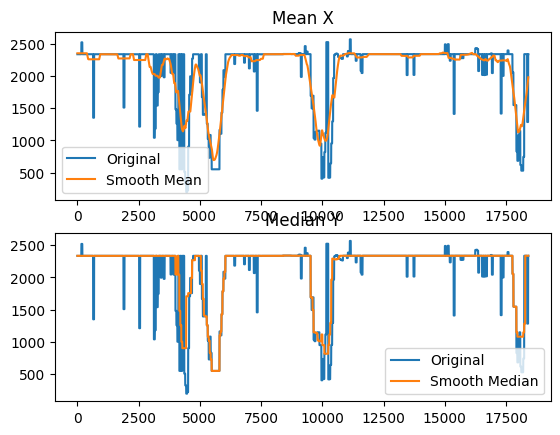

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Create an array of floats
x_vector = np.array(X)
x_smooth_vector_mean = np.array(x_smoothed_data_mean)
x_smooth_vector_median = np.array(x_smoothed_data_median)

# Create an array for the x-axis
x = np.arange(len(x_vector))
sxmean = np.arange(len(x_smooth_vector_mean))
sxmd = np.arange(len(x_smooth_vector_median))


y_vector = np.array(Y)
y_smooth_vector = np.array(y_smoothed_data)
y = np.arange(len(y_vector))
sy = np.arange(len(y_smooth_vector))

size = 20000
# Plot the vector
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x[:size], x_vector[:size], label='Original')
plt.plot(sxmean, x_smooth_vector_mean, label='Smooth Mean')
plt.title("Mean X")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x[:size], x_vector[:size], label='Original')
plt.plot(sxmd[:size], x_smooth_vector_median[:size], label='Smooth Median')
plt.title("Median Y")

# Display the plot
plt.legend()
plt.show()